# UMAP Analysis of EEG Epochs

This notebook:
1. Loads NPZ epoch files from 3 conditions: WT, WT+pilo, and KO+pilo
2. Extracts 12 features from each epoch
3. Applies 3D UMAP dimensionality reduction
4. Visualizes the results in 3D

## 1. Setup and Imports

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from pathlib import Path
from tqdm import tqdm
from scipy import signal, stats
from scipy.stats import kurtosis, skew, entropy
import umap
from sklearn.preprocessing import StandardScaler

print("✅ All imports successful!")

✅ All imports successful!


## 2. Define Feature Extraction Functions

In [142]:
def extract_features_from_epoch(data, sample_rate=256):
    """
    Extract 12 features from a single epoch.
    
    Parameters:
    -----------
    data : numpy.ndarray
        1D array of EEG signal data
    sample_rate : float
        Sampling rate in Hz (default: 256)
        
    Returns:
    --------
    features : dict
        Dictionary containing all 12 features
    """
    features = {}
    
    # Compute Power Spectral Density using Welch's method
    nperseg = min(sample_rate * 2, len(data))  # 2-second windows
    freqs, psd = signal.welch(data, fs=sample_rate, nperseg=nperseg)
    
    # Helper function to compute band power
    def band_power(psd, freqs, low, high):
        idx = np.logical_and(freqs >= low, freqs <= high)
        return np.trapz(psd[idx], freqs[idx])
    
    # Calculate total power for normalization (0.5 Hz to Nyquist frequency)
    total_power = band_power(psd, freqs, 0.5, min(250, sample_rate/2))
    
    # 1-6: Frequency Band Powers (normalized as relative power)
    # This makes powers comparable across different signal amplitudes
    if total_power > 0:
        features['Delta_Power'] = band_power(psd, freqs, 0.5, 4) / total_power
        features['Theta_Power'] = band_power(psd, freqs, 4, 8) / total_power
        features['Alpha_Power'] = band_power(psd, freqs, 8, 13) / total_power
        features['Beta_Power'] = band_power(psd, freqs, 13, 30) / total_power
        features['Gamma_Power'] = band_power(psd, freqs, 30, 80) / total_power
        features['HFO_Power'] = band_power(psd, freqs, 80, min(250, sample_rate/2)) / total_power
    else:
        # Handle edge case where total power is 0
        features['Delta_Power'] = 0
        features['Theta_Power'] = 0
        features['Alpha_Power'] = 0
        features['Beta_Power'] = 0
        features['Gamma_Power'] = 0
        features['HFO_Power'] = 0
    
    # 7: Spectral Entropy
    # Normalize PSD to probability distribution
    psd_norm = psd / np.sum(psd)
    features['Spectral_Entropy'] = entropy(psd_norm)
    
    # 8: Kurtosis (measure of tailedness)
    features['Kurtosis'] = kurtosis(data)
    
    # 9: Skewness (measure of asymmetry)
    features['Skewness'] = skew(data)
    
    # 10: Line Length (measure of signal complexity)
    features['Line_Length'] = np.sum(np.abs(np.diff(data)))
    
    # 11: Root Mean Square (RMS) amplitude
    features['RMS'] = np.sqrt(np.mean(data**2))
    
    # 12: Hjorth Complexity
    # Hjorth parameters: Activity, Mobility, Complexity
    def hjorth_complexity(signal):
        # First derivative
        d1 = np.diff(signal)
        # Second derivative
        d2 = np.diff(d1)
        
        # Activity (variance)
        activity = np.var(signal)
        
        # Mobility
        mobility = np.sqrt(np.var(d1) / activity) if activity > 0 else 0
        
        # Complexity
        complexity = (np.sqrt(np.var(d2) / np.var(d1)) / mobility) if (mobility > 0 and np.var(d1) > 0) else 0
        
        return complexity
    
    features['Hjorth_Complexity'] = hjorth_complexity(data)
    
    return features


print("✅ Feature extraction functions defined!")
print("ℹ️  Band powers are normalized as relative power (proportion of total power)")

✅ Feature extraction functions defined!
ℹ️  Band powers are normalized as relative power (proportion of total power)


## 3. Load NPZ Files and Extract Features

In [143]:
# Path to the epilepsy data directory
data_dir = "/Volumes/CHOO'S SSD/LINK/1. 박진봉 교수님 데이터/epilepsy_data"

# Define the 3 conditions (excluding KO+pilo2)
conditions = ['WT', 'WT+pilo', 'KO+pilo']

# Find files for each condition
files_by_condition = {}
for condition in conditions:
    pattern = os.path.join(data_dir, f"{condition}_256_*.npz")
    files = sorted(glob.glob(pattern))
    files_by_condition[condition] = files
    print(f"{condition}: {len(files)} files found")

print(f"\nTotal files: {sum(len(files) for files in files_by_condition.values())}")

WT: 2829 files found
WT+pilo: 3521 files found
KO+pilo: 3521 files found

Total files: 9871


In [144]:
# Extract features from all files
all_features = []
all_labels = []
all_filenames = []

sample_rate = 256  # Hz

print("Extracting features from all epochs...\n")

for condition in conditions:
    print(f"Processing {condition}...")
    files = files_by_condition[condition]
    
    for file_path in tqdm(files, desc=condition):
        try:
            # Load NPZ file
            data = np.load(file_path)
            
            # Get the channel data (either A-017 or B-017)
            if 'A-017' in data.files:
                channel_data = data['A-017']
            elif 'B-017' in data.files:
                channel_data = data['B-017']
            else:
                print(f"Warning: No A-017 or B-017 channel found in {file_path}")
                continue
            
            # Extract features
            features = extract_features_from_epoch(channel_data, sample_rate)
            
            # Store results
            all_features.append(features)
            all_labels.append(condition)
            all_filenames.append(os.path.basename(file_path))
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    print(f"  ✅ Processed {len([l for l in all_labels if l == condition])} epochs\n")

print(f"\n✅ Feature extraction complete!")
print(f"Total epochs processed: {len(all_features)}")

Extracting features from all epochs...

Processing WT...


WT:   0%|          | 0/2829 [00:00<?, ?it/s]/var/folders/g4/80l_4jg54rlcq9by8gjj21s40000gn/T/ipykernel_4190/358096863.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[idx], freqs[idx])
/var/folders/g4/80l_4jg54rlcq9by8gjj21s40000gn/T/ipykernel_4190/358096863.py:55: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['Kurtosis'] = kurtosis(data)
/var/folders/g4/80l_4jg54rlcq9by8gjj21s40000gn/T/ipykernel_4190/358096863.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['Skewness'] = skew(data)
WT:   1%|          | 28/2829 [00:00<00:10, 274.71it/s]/var/folders/g4/80l_4jg54rlcq9by8gjj21s40000gn/T/ipykernel_4190/3

  ✅ Processed 2829 epochs

Processing WT+pilo...


WT+pilo: 100%|██████████| 3521/3521 [00:13<00:00, 255.11it/s]


  ✅ Processed 3521 epochs

Processing KO+pilo...


KO+pilo: 100%|██████████| 3521/3521 [00:13<00:00, 251.92it/s]

  ✅ Processed 3521 epochs


✅ Feature extraction complete!
Total epochs processed: 9871


## 4. Create Feature DataFrame

In [145]:
# Convert to DataFrame
df_features = pd.DataFrame(all_features)
df_features['Condition'] = all_labels
df_features['Filename'] = all_filenames

# Display summary
print("Feature DataFrame:")
print(f"Shape: {df_features.shape}")
print(f"\nColumns: {list(df_features.columns)}")
print(f"\nFirst few rows:")
display(df_features.head())

# Summary by condition
print(f"\nEpochs per condition:")
print(df_features['Condition'].value_counts())

Feature DataFrame:
Shape: (9871, 14)

Columns: ['Delta_Power', 'Theta_Power', 'Alpha_Power', 'Beta_Power', 'Gamma_Power', 'HFO_Power', 'Spectral_Entropy', 'Kurtosis', 'Skewness', 'Line_Length', 'RMS', 'Hjorth_Complexity', 'Condition', 'Filename']

First few rows:


,Delta_Power,Theta_Power,Alpha_Power,Beta_Power,Gamma_Power,HFO_Power,Spectral_Entropy,Kurtosis,Skewness,Line_Length,RMS,Hjorth_Complexity,Condition,Filename
0,0.696456,0.075549,0.039268,0.088630,0.067548,0.032549,3.165749,22.733277,-2.885078,7.004443e+04,33.659416,3.649849,WT,WT_256_0.npz
1,0.765327,0.038966,0.020458,0.062849,0.068245,0.044155,2.921836,19.522847,-3.018650,9.666701e+04,41.894520,3.534806,WT,WT_256_1.npz
2,0.724609,0.052205,0.017887,0.041096,0.105826,0.058377,3.098435,11.267961,-1.909265,1.225893e+05,40.381168,2.933128,WT,WT_256_10.npz
3,0.769794,0.053993,0.020229,0.044938,0.081858,0.029188,2.931266,0.982107,-0.196808,1.132475e+05,40.605236,3.295039,WT,WT_256_100.npz
4,0.055669,0.030511,0.036283,0.130420,0.378861,0.368256,5.389104,-0.179144,-0.050362,1.973240e-08,6388.980000,1.335316,WT,WT_256_1000.npz



Epochs per condition:
Condition
WT+pilo    3521
KO+pilo    3521
WT         2829
Name: count, dtype: int64


## 5. Feature Statistics

In [146]:
# Display feature statistics
feature_columns = [col for col in df_features.columns if col not in ['Condition', 'Filename']]

print("Feature Statistics:\n")
display(df_features[feature_columns].describe())

# Check for any NaN or Inf values
print(f"\nNaN values per feature:")
print(df_features[feature_columns].isna().sum())

print(f"\nInf values per feature:")
print(df_features[feature_columns].isin([np.inf, -np.inf]).sum())

Feature Statistics:



,Delta_Power,Theta_Power,Alpha_Power,Beta_Power,Gamma_Power,HFO_Power,Spectral_Entropy,Kurtosis,Skewness,Line_Length,RMS,Hjorth_Complexity
count,9.871000e+03,9.871000e+03,9.871000e+03,9.871000e+03,9.871000e+03,9871.000000,9871.000000,9871.000000,9871.000000,9.871000e+03,9871.000000,9871.000000
mean,3.518128e-01,2.001862e-01,9.257713e-02,1.038785e-01,1.570606e-01,0.094485,4.186521,1.362769,0.208490,1.639452e+05,1019.409607,2.568553
std,1.743556e-01,8.978673e-02,4.574445e-02,3.315164e-02,1.080481e-01,0.118911,0.654239,6.129125,0.543918,1.239055e+05,2271.964301,1.015720
min,2.410552e-10,1.252589e-19,4.858102e-19,8.659175e-18,1.158125e-15,0.000166,0.636529,-1.961591,-7.367986,1.941498e-08,16.745755,1.000000
25%,2.424191e-01,1.581160e-01,4.889681e-02,7.872915e-02,7.497263e-02,0.018680,3.749443,0.164008,0.026344,8.401785e+04,36.156406,2.019597
50%,3.812230e-01,2.181041e-01,8.851223e-02,1.050699e-01,1.342364e-01,0.037980,4.068612,0.485824,0.154965,1.187003e+05,63.365890,2.453171
75%,4.618906e-01,2.633790e-01,1.242025e-01,1.323157e-01,1.798035e-01,0.103452,4.507012,1.017422,0.305919,2.627461e+05,90.860604,3.042529
max,9.809895e-01,4.892034e-01,3.985281e-01,2.199015e-01,4.000701e-01,1.000000,5.496780,283.054927,8.370546,1.051316e+06,6388.985116,37.133839



NaN values per feature:
Delta_Power          0
Theta_Power          0
Alpha_Power          0
Beta_Power           0
Gamma_Power          0
HFO_Power            0
Spectral_Entropy     0
Kurtosis             0
Skewness             0
Line_Length          0
RMS                  0
Hjorth_Complexity    0
dtype: int64

Inf values per feature:
Delta_Power          0
Theta_Power          0
Alpha_Power          0
Beta_Power           0
Gamma_Power          0
HFO_Power            0
Spectral_Entropy     0
Kurtosis             0
Skewness             0
Line_Length          0
RMS                  0
Hjorth_Complexity    0
dtype: int64


In [147]:
# Handle any NaN or Inf values
# Replace inf with nan, then fill nan with column median
df_features_clean = df_features.copy()
for col in feature_columns:
    # Replace inf with nan
    df_features_clean[col] = df_features_clean[col].replace([np.inf, -np.inf], np.nan)
    # Fill nan with median
    if df_features_clean[col].isna().any():
        median_val = df_features_clean[col].median()
        df_features_clean[col].fillna(median_val, inplace=True)
        print(f"Filled NaN/Inf values in {col} with median: {median_val:.4f}")

print("\n✅ Data cleaning complete!")


✅ Data cleaning complete!


## 6. Standardize Features

In [148]:
# Standardize features (zero mean, unit variance)
scaler = StandardScaler()
X = df_features_clean[feature_columns].values
X_scaled = scaler.fit_transform(X)

print(f"✅ Features standardized!")
print(f"Original shape: {X.shape}")
print(f"Scaled shape: {X_scaled.shape}")
print(f"\nScaled data statistics:")
print(f"  Mean: {X_scaled.mean(axis=0)[:5]}... (should be ~0)")
print(f"  Std:  {X_scaled.std(axis=0)[:5]}... (should be ~1)")

✅ Features standardized!
Original shape: (9871, 12)
Scaled shape: (9871, 12)

Scaled data statistics:
  Mean: [-1.61241589e-16  1.15172564e-16 -4.60690255e-17 -1.84276102e-16
 -6.91035383e-17]... (should be ~0)
  Std:  [1. 1. 1. 1. 1.]... (should be ~1)


## 7. Apply UMAP

In [149]:
# Apply UMAP dimensionality reduction
print("Applying 3D UMAP...\n")

# UMAP parameters
n_neighbors = 15  # Number of neighbors to consider
min_dist = 0.1    # Minimum distance between points in embedding
n_components = 3  # Number of dimensions to reduce to (3D)

reducer = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=42,
    verbose=True
)

embedding = reducer.fit_transform(X_scaled)

print(f"\n✅ UMAP complete!")
print(f"Embedding shape: {embedding.shape}")

/opt/miniconda3/envs/eeg/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Applying 3D UMAP...

UMAP(n_components=3, n_jobs=1, random_state=42, verbose=True)
Tue Oct 28 20:56:12 2025 Construct fuzzy simplicial set
Tue Oct 28 20:56:12 2025 Finding Nearest Neighbors
Tue Oct 28 20:56:12 2025 Building RP forest with 10 trees
Tue Oct 28 20:56:12 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Tue Oct 28 20:56:12 2025 Finished Nearest Neighbor Search
Tue Oct 28 20:56:12 2025 Construct embedding
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Tue Oct 28 20:56:12 2025 Finished Nearest Neighbor Search
Tue Oct 28 20:56:12 2025 Construct embedding


Epochs completed:   4%| ▎          18/500 [00:00]

	completed  0  /  500 epochs


Epochs completed:  12%| █▏         59/500 [00:01]

	completed  50  /  500 epochs


Epochs completed:  21%| ██         105/500 [00:02]

	completed  100  /  500 epochs


Epochs completed:  32%| ███▏       162/500 [00:04]

	completed  150  /  500 epochs


Epochs completed:  42%| ████▏      211/500 [00:05]

	completed  200  /  500 epochs


Epochs completed:  53%| █████▎     263/500 [00:06]

	completed  250  /  500 epochs


Epochs completed:  63%| ██████▎    314/500 [00:07]

	completed  300  /  500 epochs


Epochs completed:  73%| ███████▎   364/500 [00:09]

	completed  350  /  500 epochs


Epochs completed:  82%| ████████▏  411/500 [00:10]

	completed  400  /  500 epochs


Epochs completed:  92%| █████████▏ 461/500 [00:11]

	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:12]

Tue Oct 28 20:56:25 2025 Finished embedding

✅ UMAP complete!
Embedding shape: (9871, 3)


## 8. Visualize 3D UMAP Results


💾 Figure saved to: /Users/sean/LINK/MEEG/Figure/results/umap_3d_visualization.png


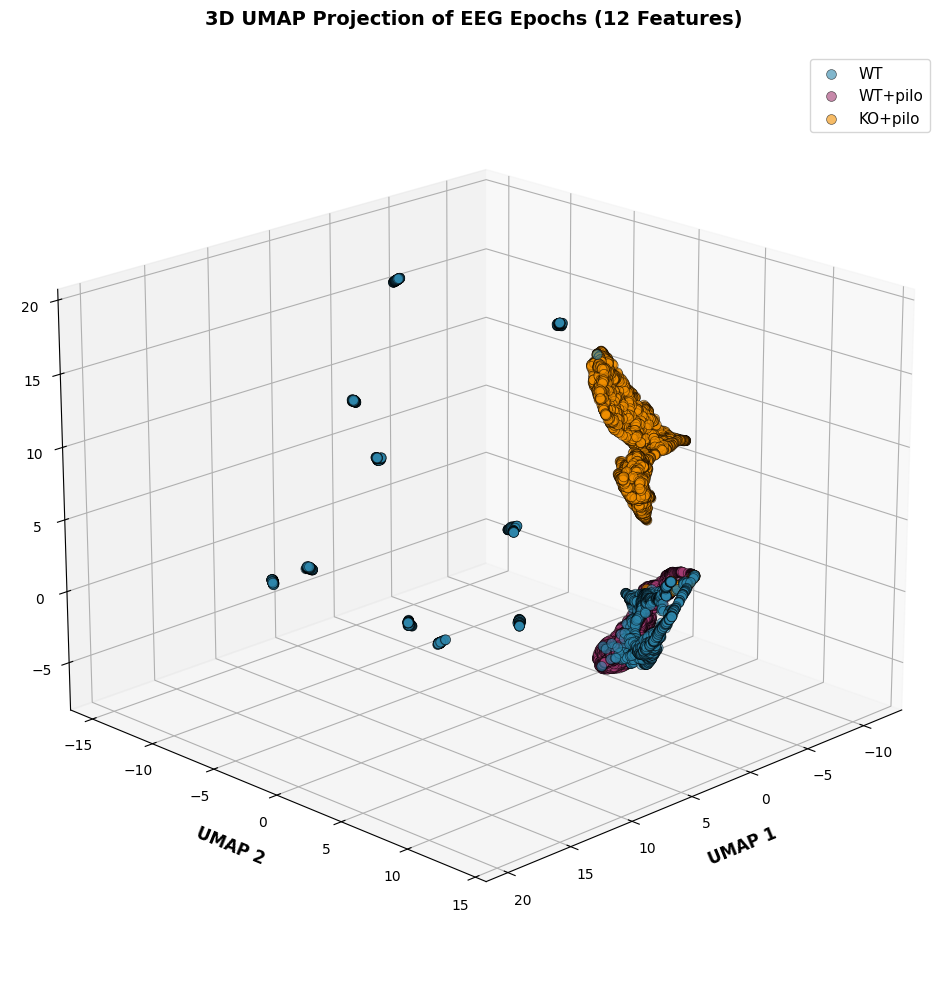

In [150]:
from mpl_toolkits.mplot3d import Axes3D

# Create DataFrame with UMAP coordinates
df_umap = pd.DataFrame({
    'UMAP1': embedding[:, 0],
    'UMAP2': embedding[:, 1],
    'UMAP3': embedding[:, 2],
    'Condition': df_features_clean['Condition']
})

# Define colors for each condition (excluding KO+pilo2)
color_map = {
    'WT': '#2E86AB',        # Blue
    'WT+pilo': '#A23B72',   # Purple
    'KO+pilo': '#F18F01'    # Orange
}

# Create 3D scatter plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

for condition in conditions:
    mask = df_umap['Condition'] == condition
    ax.scatter(
        df_umap.loc[mask, 'UMAP1'],
        df_umap.loc[mask, 'UMAP2'],
        df_umap.loc[mask, 'UMAP3'],
        c=color_map[condition],
        label=condition,
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

ax.set_xlabel('UMAP 1', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('UMAP 2', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('UMAP 3', fontsize=12, fontweight='bold', labelpad=10)
ax.set_title('3D UMAP Projection of EEG Epochs (12 Features)', fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper right')

# Adjust viewing angle for better visualization
ax.view_init(elev=20, azim=45)

plt.tight_layout()

# Save figure
output_path = "/Users/sean/LINK/MEEG/Figure/results/umap_3d_visualization.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n💾 Figure saved to: {output_path}")

plt.show()

## 8.5. Remove UMAP Outliers (WT Condition)

In [151]:
# Detect outliers based on distance from WT cluster center (WT condition only)
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist

# Get WT data in UMAP space
wt_mask = df_umap['Condition'] == 'WT'
wt_umap_coords = df_umap.loc[wt_mask, ['UMAP1', 'UMAP2', 'UMAP3']].values

print(f"Total WT epochs before outlier removal: {wt_mask.sum()}")

# Method 1: Find the main cluster using DBSCAN
# This identifies the dense core of WT data
dbscan = DBSCAN(eps=14.1, min_samples=200)
cluster_labels = dbscan.fit_predict(wt_umap_coords)

# Find the largest cluster (main WT cluster)
unique_labels, counts = np.unique(cluster_labels[cluster_labels != -1], return_counts=True)
if len(unique_labels) > 0:
    main_cluster_label = unique_labels[np.argmax(counts)]
    main_cluster_mask = cluster_labels == main_cluster_label
    print(f"Main WT cluster size: {main_cluster_mask.sum()} epochs")
    
    # Calculate center of main cluster
    cluster_center = wt_umap_coords[main_cluster_mask].mean(axis=0)
    
    # Calculate distances from cluster center
    distances = np.sqrt(np.sum((wt_umap_coords - cluster_center)**2, axis=1))
    
    # Use percentile-based threshold (keep only points close to center)
    # This will keep the 70% closest points to the cluster center
    distance_threshold = np.percentile(distances[main_cluster_mask], 99.9)
    
    # Mark outliers: points that are far from the cluster OR labeled as noise by DBSCAN
    outlier_labels = (distances > distance_threshold) | (cluster_labels == -1)
else:
    # Fallback: if no cluster found, use distance from median
    cluster_center = np.median(wt_umap_coords, axis=0)
    distances = np.sqrt(np.sum((wt_umap_coords - cluster_center)**2, axis=1))
    distance_threshold = np.percentile(distances, 99)
    outlier_labels = distances > distance_threshold

# -1 indicates outlier, 1 indicates inlier
n_outliers = outlier_labels.sum()
print(f"Number of UMAP outliers detected: {n_outliers}")
print(f"Percentage removed: {n_outliers / len(wt_umap_coords) * 100:.1f}%")

# Get indices of outliers
wt_indices = df_umap[wt_mask].index
outlier_indices = wt_indices[outlier_labels]

print(f"\nOutlier files to be removed:")
for idx in outlier_indices[:10]:  # Show first 10
    print(f"  - {df_features_clean.loc[idx, 'Filename']}")
if len(outlier_indices) > 10:
    print(f"  ... and {len(outlier_indices) - 10} more")

# Create mask to keep only inliers
keep_mask = ~df_umap.index.isin(outlier_indices)

# Apply the mask to both dataframes
df_umap_filtered = df_umap[keep_mask].copy()
df_features_filtered = df_features_clean[keep_mask].copy()
embedding_filtered = embedding[keep_mask]

print(f"\n✅ UMAP outliers removed!")
print(f"WT epochs after removal: {(df_umap_filtered['Condition'] == 'WT').sum()}")
print(f"Total epochs after removal: {len(df_umap_filtered)}")
print(f"\nEpochs per condition after outlier removal:")
print(df_umap_filtered['Condition'].value_counts())

Total WT epochs before outlier removal: 2829
Main WT cluster size: 1331 epochs
Number of UMAP outliers detected: 1500
Percentage removed: 53.0%

Outlier files to be removed:
  - WT_256_1000.npz
  - WT_256_1001.npz
  - WT_256_1002.npz
  - WT_256_1003.npz
  - WT_256_1004.npz
  - WT_256_1005.npz
  - WT_256_1006.npz
  - WT_256_1007.npz
  - WT_256_1008.npz
  - WT_256_1009.npz
  ... and 1490 more

✅ UMAP outliers removed!
WT epochs after removal: 1329
Total epochs after removal: 8371

Epochs per condition after outlier removal:
Condition
WT+pilo    3521
KO+pilo    3521
WT         1329
Name: count, dtype: int64


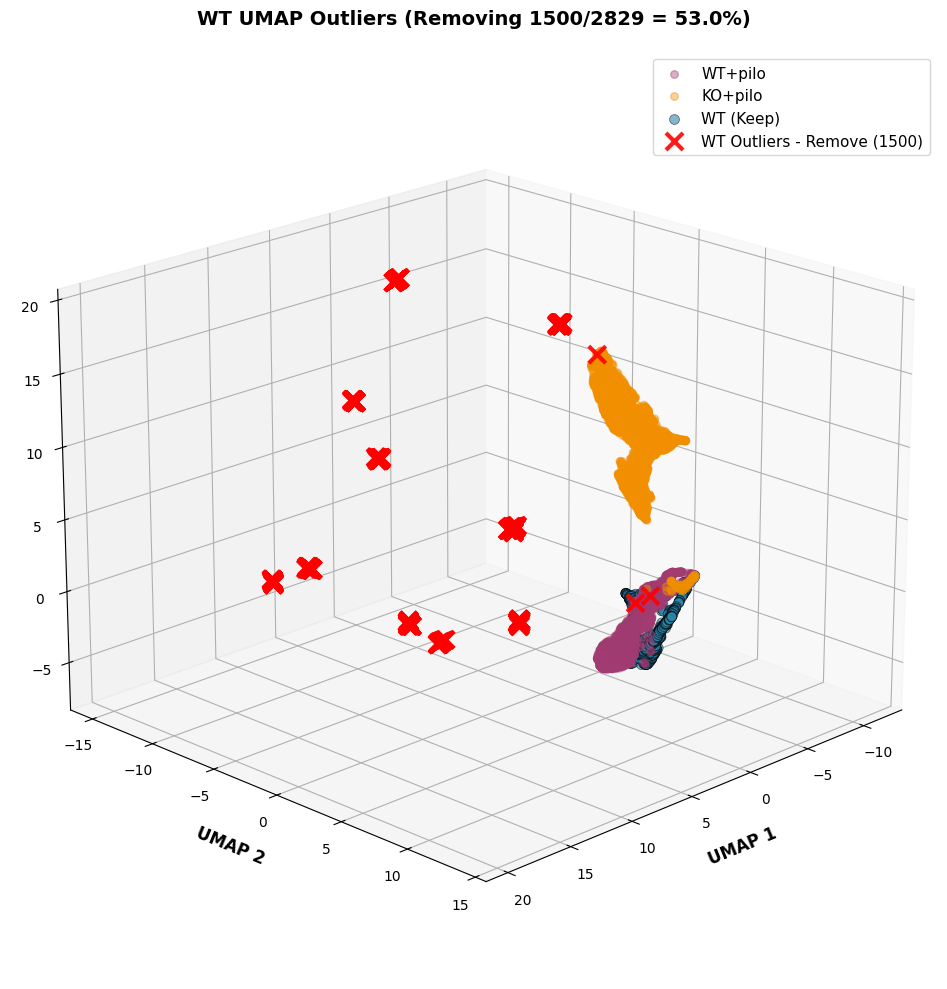

✅ Visualization complete. Red X markers (1500 points) show UMAP outliers to be removed.


In [152]:
# Visualize outliers in UMAP space (before removal)
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot all conditions in light gray
for condition in conditions:
    if condition != 'WT':
        mask = df_umap['Condition'] == condition
        ax.scatter(
            df_umap.loc[mask, 'UMAP1'],
            df_umap.loc[mask, 'UMAP2'],
            df_umap.loc[mask, 'UMAP3'],
            c=color_map[condition],
            label=condition,
            alpha=0.4,
            s=30
        )

# Plot WT inliers
wt_inlier_mask_full = df_umap.index.isin(wt_indices[~outlier_labels])
ax.scatter(
    df_umap.loc[wt_inlier_mask_full, 'UMAP1'],
    df_umap.loc[wt_inlier_mask_full, 'UMAP2'],
    df_umap.loc[wt_inlier_mask_full, 'UMAP3'],
    c='#2E86AB',
    label='WT (Keep)',
    alpha=0.6,
    s=50,
    edgecolors='black',
    linewidth=0.5
)

# Plot WT outliers
wt_outlier_mask_full = df_umap.index.isin(outlier_indices)
ax.scatter(
    df_umap.loc[wt_outlier_mask_full, 'UMAP1'],
    df_umap.loc[wt_outlier_mask_full, 'UMAP2'],
    df_umap.loc[wt_outlier_mask_full, 'UMAP3'],
    c='red',
    label=f'WT Outliers - Remove ({n_outliers})',
    alpha=0.9,
    s=150,
    marker='x',
    linewidth=3
)

ax.set_xlabel('UMAP 1', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('UMAP 2', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('UMAP 3', fontsize=12, fontweight='bold', labelpad=10)
ax.set_title(f'WT UMAP Outliers (Removing {n_outliers}/{wt_mask.sum()} = {n_outliers/wt_mask.sum()*100:.1f}%)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper right')
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

print(f"✅ Visualization complete. Red X markers ({n_outliers} points) show UMAP outliers to be removed.")

## 8.6. Re-plot 3D UMAP (After Outlier Removal)


💾 Figure saved to: /Users/sean/LINK/MEEG/Figure/results/umap_3d_cleaned.png


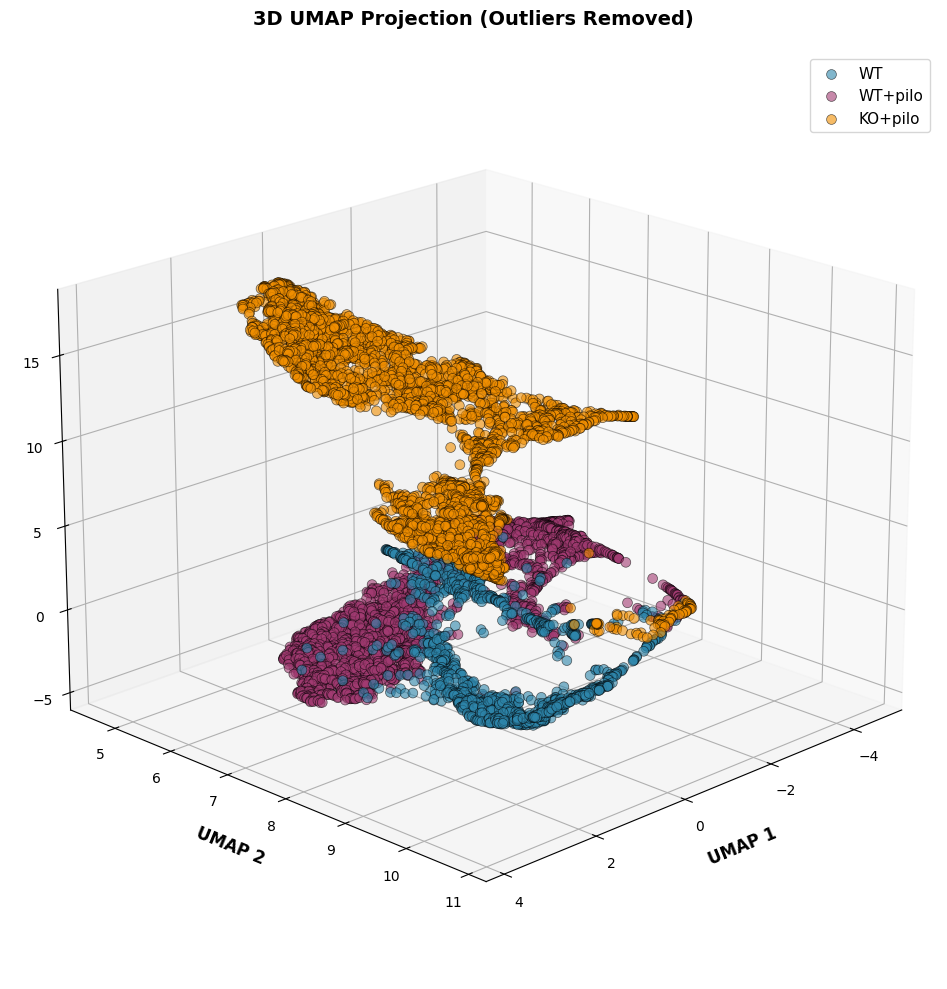

In [153]:
# Re-plot 3D UMAP with outliers removed
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

for condition in conditions:
    mask = df_umap_filtered['Condition'] == condition
    ax.scatter(
        df_umap_filtered.loc[mask, 'UMAP1'],
        df_umap_filtered.loc[mask, 'UMAP2'],
        df_umap_filtered.loc[mask, 'UMAP3'],
        c=color_map[condition],
        label=condition,
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

ax.set_xlabel('UMAP 1', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('UMAP 2', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('UMAP 3', fontsize=12, fontweight='bold', labelpad=10)
ax.set_title('3D UMAP Projection (Outliers Removed)', fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper right')
ax.view_init(elev=20, azim=45)

plt.tight_layout()

# Save figure
output_path = "/Users/sean/LINK/MEEG/Figure/results/umap_3d_cleaned.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n💾 Figure saved to: {output_path}")

plt.show()

## 9. Multiple Views of 3D UMAP


💾 Figure saved to: /Users/sean/LINK/MEEG/Figure/results/umap_3d_multiple_views.png


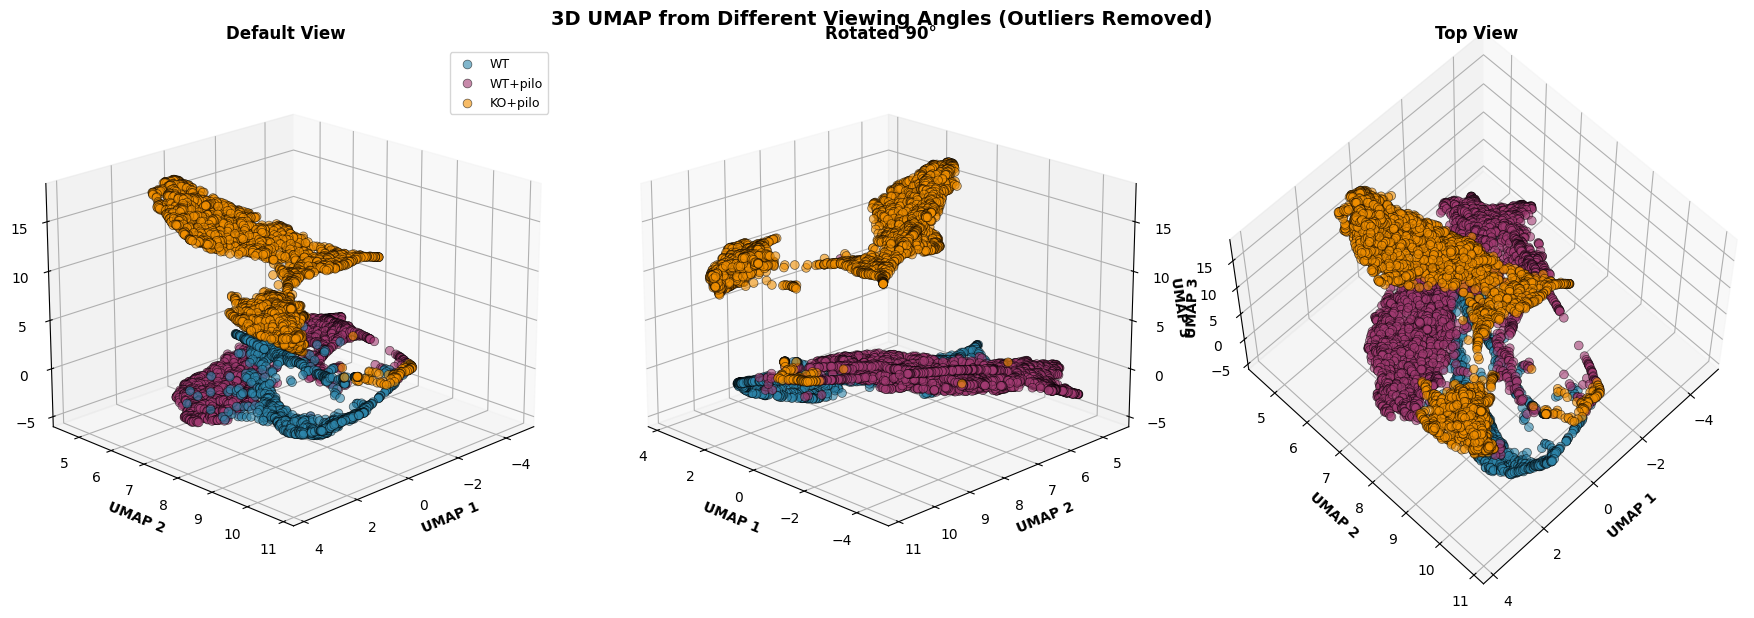

In [154]:
# Create figure with multiple viewing angles of the 3D UMAP (using filtered data)
fig = plt.figure(figsize=(18, 6))

# Define different viewing angles
angles = [
    (20, 45, 'Default View'),
    (20, 135, 'Rotated 90°'),
    (60, 45, 'Top View')
]

for idx, (elev, azim, title) in enumerate(angles):
    ax = fig.add_subplot(1, 3, idx+1, projection='3d')
    
    for condition in conditions:
        mask = df_umap_filtered['Condition'] == condition
        ax.scatter(
            df_umap_filtered.loc[mask, 'UMAP1'],
            df_umap_filtered.loc[mask, 'UMAP2'],
            df_umap_filtered.loc[mask, 'UMAP3'],
            c=color_map[condition],
            label=condition,
            alpha=0.6,
            s=40,
            edgecolors='black',
            linewidth=0.5
        )
    
    ax.set_xlabel('UMAP 1', fontsize=10, fontweight='bold')
    ax.set_ylabel('UMAP 2', fontsize=10, fontweight='bold')
    ax.set_zlabel('UMAP 3', fontsize=10, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.view_init(elev=elev, azim=azim)
    
    if idx == 0:
        ax.legend(fontsize=9, loc='upper right')

plt.suptitle('3D UMAP from Different Viewing Angles (Outliers Removed)', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()

# Save figure
output_path = "/Users/sean/LINK/MEEG/Figure/results/umap_3d_multiple_views.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n💾 Figure saved to: {output_path}")

plt.show()

## 9.5. Single View: Rotated 90° (Standalone)

💾 Figure saved to: /Users/sean/LINK/MEEG/Figure/results/umap_3d_rotated_90deg.png


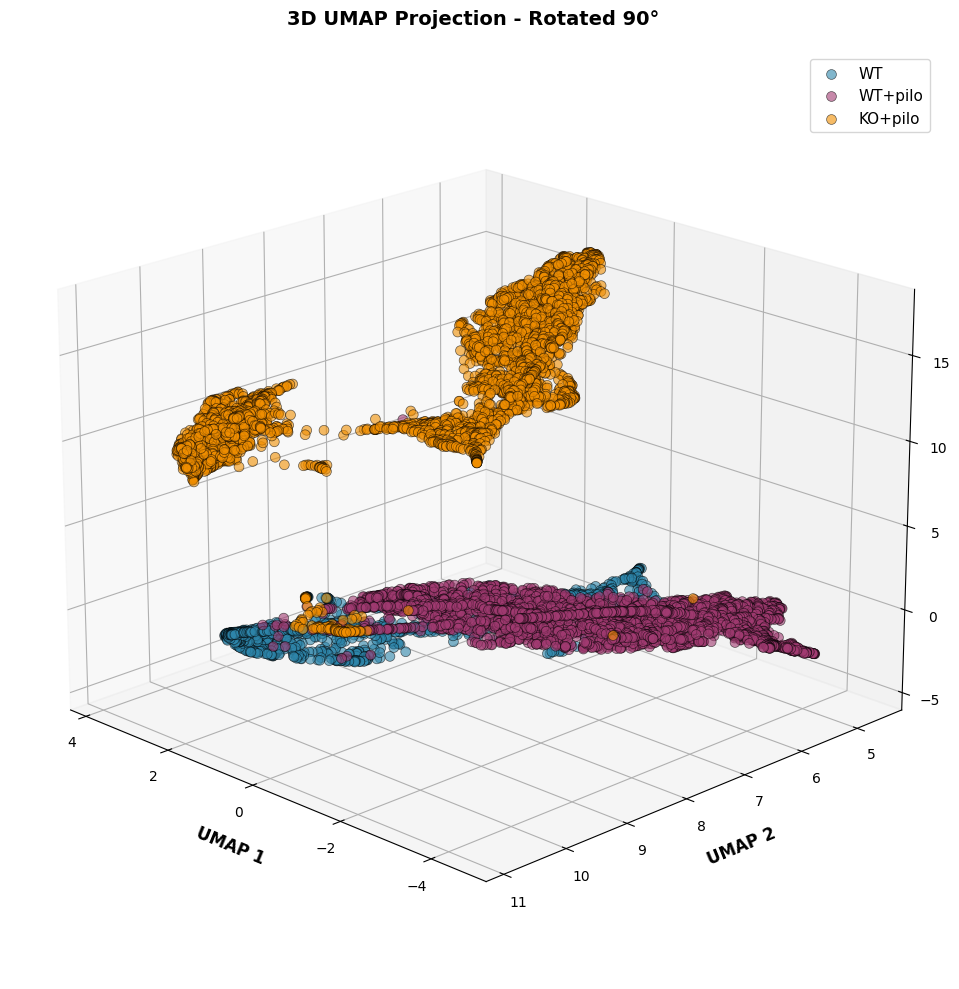

In [155]:
# Create single 3D view rotated 90°
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for condition in conditions:
    mask = df_umap_filtered['Condition'] == condition
    ax.scatter(
        df_umap_filtered.loc[mask, 'UMAP1'],
        df_umap_filtered.loc[mask, 'UMAP2'],
        df_umap_filtered.loc[mask, 'UMAP3'],
        c=color_map[condition],
        label=condition,
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

ax.set_xlabel('UMAP 1', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('UMAP 2', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('UMAP 3', fontsize=12, fontweight='bold', labelpad=10)
ax.set_title('3D UMAP Projection - Rotated 90°', fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper right')
ax.view_init(elev=20, azim=135)  # Rotated 90° view

plt.tight_layout()

# Save figure
output_path = "/Users/sean/LINK/MEEG/Figure/results/umap_3d_rotated_90deg.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"💾 Figure saved to: {output_path}")

plt.show()

## 9.6. 3-Plane 2D Projections (XY, XZ, YZ)

💾 Figure saved to: /Users/sean/LINK/MEEG/Figure/results/umap_2d_projection_xy.png


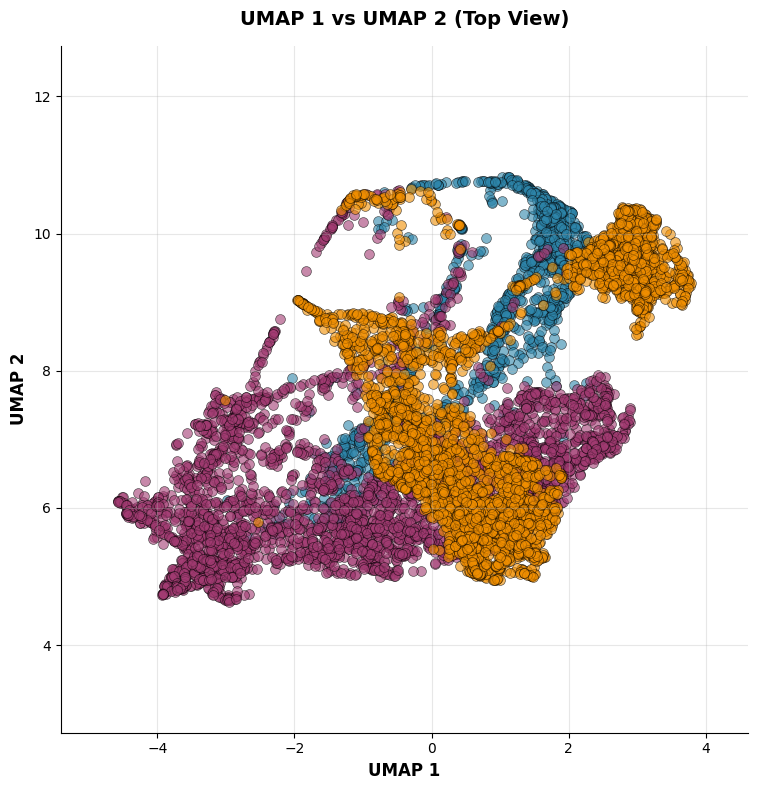

💾 Figure saved to: /Users/sean/LINK/MEEG/Figure/results/umap_2d_projection_xz.png


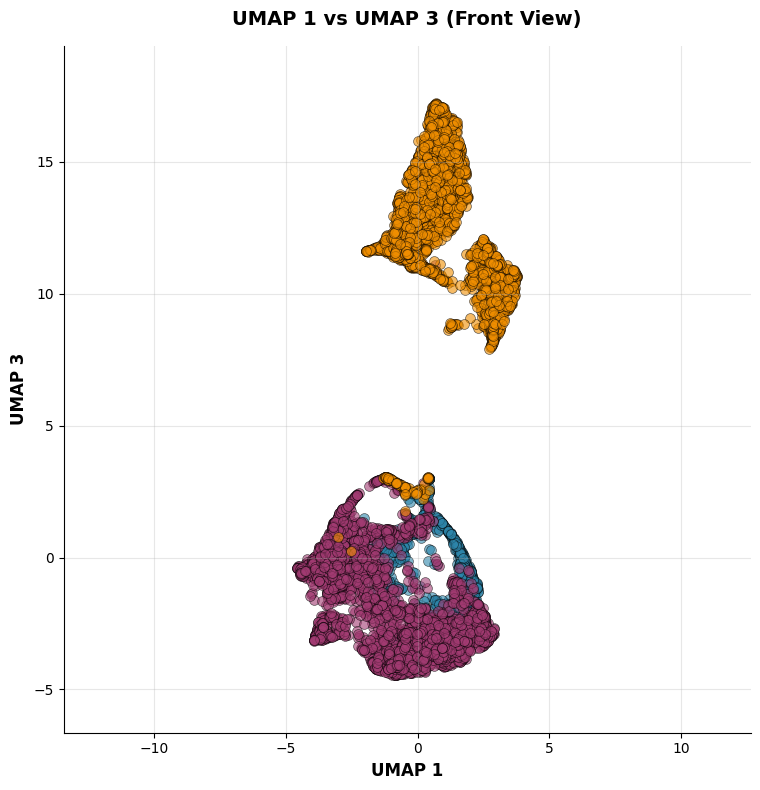

💾 Figure saved to: /Users/sean/LINK/MEEG/Figure/results/umap_2d_projection_yz.png


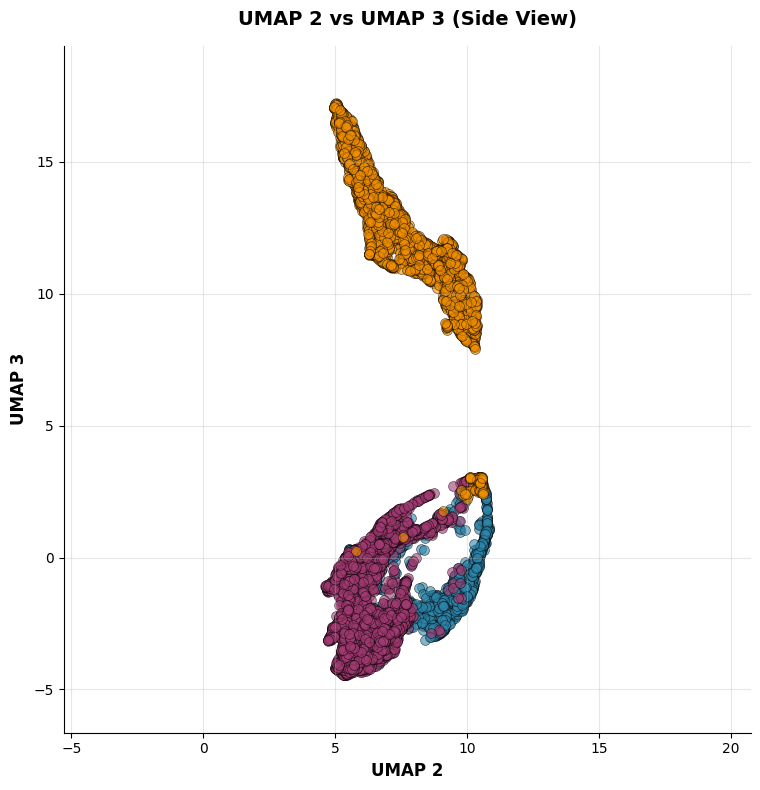


✅ All three 2D projection PNG files created successfully!


In [167]:
# Create 3-plane 2D projections as individual square PNG files

# Define the three 2D projections
projections = [
    ('UMAP1', 'UMAP2', 'UMAP 1 vs UMAP 2 (Top View)', 'umap_2d_projection_xy.png'),
    ('UMAP1', 'UMAP3', 'UMAP 1 vs UMAP 3 (Front View)', 'umap_2d_projection_xz.png'),
    ('UMAP2', 'UMAP3', 'UMAP 2 vs UMAP 3 (Side View)', 'umap_2d_projection_yz.png')
]

for x_dim, y_dim, title, filename in projections:
    # Create individual square figure
    fig, ax = plt.subplots(figsize=(8, 8))
    
    for condition in conditions:
        mask = df_umap_filtered['Condition'] == condition
        ax.scatter(
            df_umap_filtered.loc[mask, x_dim],
            df_umap_filtered.loc[mask, y_dim],
            c=color_map[condition],
            label=condition,
            alpha=0.6,
            s=50,
            edgecolors='black',
            linewidth=0.5
        )
    
    ax.set_xlabel(x_dim.replace('UMAP', 'UMAP '), fontsize=12, fontweight='bold')
    ax.set_ylabel(y_dim.replace('UMAP', 'UMAP '), fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Get data ranges for both dimensions
    x_min, x_max = df_umap_filtered[x_dim].min(), df_umap_filtered[x_dim].max()
    y_min, y_max = df_umap_filtered[y_dim].min(), df_umap_filtered[y_dim].max()
    
    # Calculate the maximum range
    x_range = x_max - x_min
    y_range = y_max - y_min
    max_range = max(x_range, y_range)
    
    # Calculate centers
    x_center = (x_max + x_min) / 2
    y_center = (y_max + y_min) / 2
    
    # Set equal limits based on max range
    margin = max_range * 0.1  # 10% margin
    ax.set_xlim(x_center - max_range/2 - margin, x_center + max_range/2 + margin)
    ax.set_ylim(y_center - max_range/2 - margin, y_center + max_range/2 + margin)
    
    # Set equal aspect ratio for square plots
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    
    # Save individual figure
    output_path = f"/Users/sean/LINK/MEEG/Figure/results/{filename}"
    fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"💾 Figure saved to: {output_path}")
    
    plt.show()
    plt.close()

print("\n✅ All three 2D projection PNG files created successfully!")

## 10. Feature Importance Analysis


💾 Figure saved to: /Users/sean/LINK/MEEG/Figure/results/umap_feature_importance.png


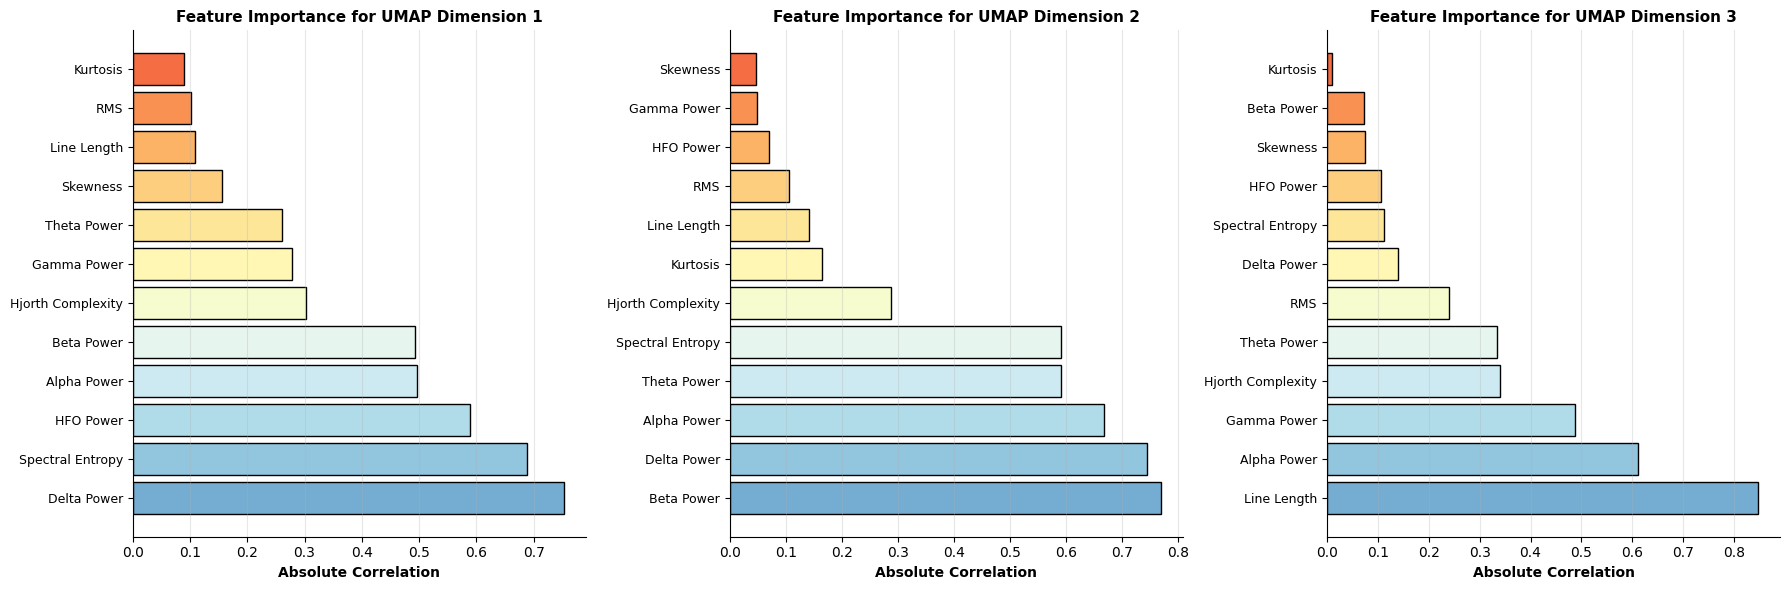


Top 5 most important features for each UMAP dimension:

UMAP1:
1. Delta Power: 0.753
2. Spectral Entropy: 0.689
3. HFO Power: 0.589
4. Alpha Power: 0.496
5. Beta Power: 0.494

UMAP2:
1. Beta Power: 0.770
2. Delta Power: 0.744
3. Alpha Power: 0.668
4. Theta Power: 0.592
5. Spectral Entropy: 0.591

UMAP3:
1. Line Length: 0.848
2. Alpha Power: 0.611
3. Gamma Power: 0.488
4. Hjorth Complexity: 0.340
5. Theta Power: 0.334


In [157]:
# Correlation between original features and UMAP components (using filtered data)
# Need to get the scaled features for the filtered indices
keep_mask_array = df_features_clean.index.isin(df_umap_filtered.index)
X_scaled_filtered = X_scaled[keep_mask_array]

df_correlation = pd.DataFrame(X_scaled_filtered, columns=feature_columns)
df_correlation['UMAP1'] = embedding_filtered[:, 0]
df_correlation['UMAP2'] = embedding_filtered[:, 1]
df_correlation['UMAP3'] = embedding_filtered[:, 2]

# Calculate correlations with all three UMAP dimensions
correlations_1 = df_correlation[feature_columns].corrwith(df_correlation['UMAP1']).abs()
correlations_2 = df_correlation[feature_columns].corrwith(df_correlation['UMAP2']).abs()
correlations_3 = df_correlation[feature_columns].corrwith(df_correlation['UMAP3']).abs()

# Create combined plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (correlations, title) in enumerate([
    (correlations_1.sort_values(ascending=False), 'UMAP Dimension 1'),
    (correlations_2.sort_values(ascending=False), 'UMAP Dimension 2'),
    (correlations_3.sort_values(ascending=False), 'UMAP Dimension 3')
]):
    ax = axes[idx]
    colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(correlations)))
    ax.barh(range(len(correlations)), correlations.values, color=colors, edgecolor='black', linewidth=1)
    ax.set_yticks(range(len(correlations)))
    ax.set_yticklabels([label.replace('_', ' ') for label in correlations.index], fontsize=9)
    ax.set_xlabel('Absolute Correlation', fontsize=10, fontweight='bold')
    ax.set_title(f'Feature Importance for {title}', fontsize=11, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()

# Save figure
output_path = "/Users/sean/LINK/MEEG/Figure/results/umap_feature_importance.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n💾 Figure saved to: {output_path}")

plt.show()

print("\nTop 5 most important features for each UMAP dimension:")
print("\nUMAP1:")
for i, (feature, corr) in enumerate(correlations_1.sort_values(ascending=False).head(5).items(), 1):
    print(f"{i}. {feature.replace('_', ' ')}: {corr:.3f}")
print("\nUMAP2:")
for i, (feature, corr) in enumerate(correlations_2.sort_values(ascending=False).head(5).items(), 1):
    print(f"{i}. {feature.replace('_', ' ')}: {corr:.3f}")
print("\nUMAP3:")
for i, (feature, corr) in enumerate(correlations_3.sort_values(ascending=False).head(5).items(), 1):
    print(f"{i}. {feature.replace('_', ' ')}: {corr:.3f}")

## 11. Save Results

In [158]:
# Save UMAP results with features (using filtered data)
df_results = df_features_filtered.copy()
df_results['UMAP1'] = embedding_filtered[:, 0]
df_results['UMAP2'] = embedding_filtered[:, 1]
df_results['UMAP3'] = embedding_filtered[:, 2]

# Save to CSV
output_csv = "/Users/sean/LINK/MEEG/Figure/results/umap_3d_results_with_features.csv"
df_results.to_csv(output_csv, index=False)
print(f"✅ Results saved to: {output_csv}")

# Display summary
print(f"\nSummary:")
print(f"  Total epochs: {len(df_results)}")
print(f"  Features extracted: {len(feature_columns)}")
print(f"  Conditions: {conditions}")
print(f"\nEpochs per condition:")
print(df_results['Condition'].value_counts())

✅ Results saved to: /Users/sean/LINK/MEEG/Figure/results/umap_3d_results_with_features.csv

Summary:
  Total epochs: 8371
  Features extracted: 12
  Conditions: ['WT', 'WT+pilo', 'KO+pilo']

Epochs per condition:
Condition
WT+pilo    3521
KO+pilo    3521
WT         1329
Name: count, dtype: int64


## 12. Summary Statistics by Condition

Mean feature values by condition:



,Delta_Power,Theta_Power,Alpha_Power,Beta_Power,Gamma_Power,HFO_Power,Spectral_Entropy,Kurtosis,Skewness,Line_Length,RMS,Hjorth_Complexity
Condition,,,,,,,,,,,,
KO+pilo,0.438244,0.208647,0.069568,0.089909,0.143570,0.050062,3.960125,1.707949,0.143606,307070.066626,85.991376,2.440168
WT,0.506112,0.206870,0.094096,0.090711,0.076706,0.025506,3.663015,1.539478,-0.038040,100257.531362,52.934482,3.691403
WT+pilo,0.334867,0.259747,0.136603,0.109471,0.104594,0.054718,4.101173,1.565330,0.281485,114592.887354,35.518884,2.777673



💾 Figure saved to: /Users/sean/LINK/MEEG/Figure/results/feature_heatmap_by_condition.png


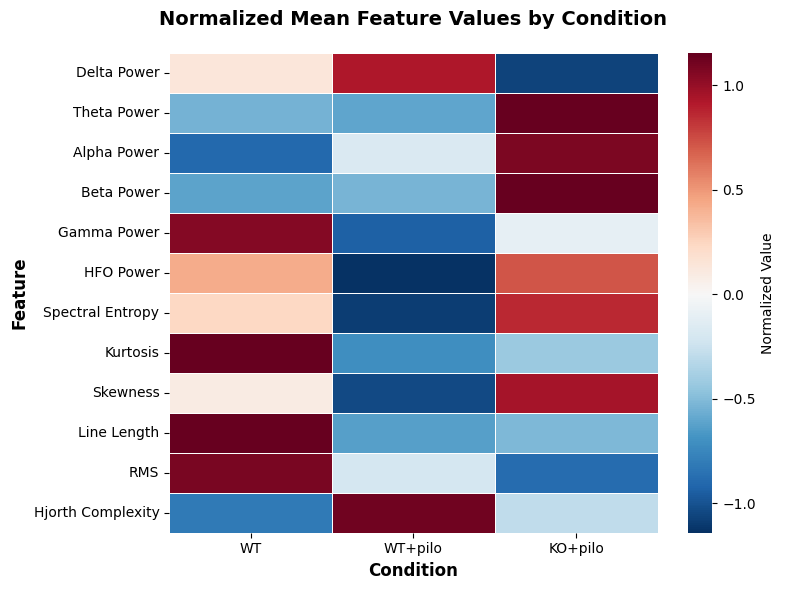

In [160]:
# Calculate mean features per condition
print("Mean feature values by condition:\n")
summary_stats = df_results.groupby('Condition')[feature_columns].mean()
display(summary_stats)

# Create heatmap of mean features
fig, ax = plt.subplots(figsize=(8, 6))

# Normalize for better visualization
summary_normalized = (summary_stats - summary_stats.mean()) / summary_stats.std()

sns.heatmap(summary_normalized.T, annot=False, cmap='RdBu_r', center=0, 
            cbar_kws={'label': 'Normalized Value'}, linewidths=0.5,
            xticklabels=conditions, yticklabels=[f.replace('_', ' ') for f in feature_columns],
            ax=ax)

ax.set_title('Normalized Mean Feature Values by Condition', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Condition', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')

plt.tight_layout()

# Save figure
output_path = "/Users/sean/LINK/MEEG/Figure/results/feature_heatmap_by_condition.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n💾 Figure saved to: {output_path}")

plt.show()

## 13. Color Legend (Horizontal)

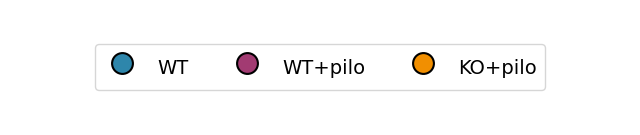


Horizontal legend saved to: /Users/sean/LINK/MEEG/Figure/results/umap_legend_horizontal.png


In [163]:
# Create horizontal legend as a separate PNG file
fig_legend, ax_legend = plt.subplots(figsize=(8, 1.5))
ax_legend.axis('off')

# Create custom legend handles with circular markers
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['WT'], 
           markersize=15, markeredgecolor='black', markeredgewidth=1.5, label='WT'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['WT+pilo'], 
           markersize=15, markeredgecolor='black', markeredgewidth=1.5, label='WT+pilo'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map['KO+pilo'], 
           markersize=15, markeredgecolor='black', markeredgewidth=1.5, label='KO+pilo')
]

# Create horizontal legend
legend = ax_legend.legend(
    handles=legend_elements,
    loc='center',
    ncol=3,
    frameon=True,
    fontsize=14,
    handlelength=2,
    handleheight=2,
    columnspacing=2
)

# Save the legend
legend_path = "/Users/sean/LINK/MEEG/Figure/results/umap_legend_horizontal.png"
plt.savefig(legend_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nHorizontal legend saved to: {legend_path}")